In [1]:
import tensorflow as tf
tf.__version__

'2.5.0'

In [2]:
import konlpy
import sklearn
import tensorflow

print(konlpy.__version__) # 0.5.2
print(sklearn.__version__) # 1.0.2
print(tensorflow.__version__) # 2.8.0

0.5.2
1.1.1
2.5.0


# 1. 데이터 수집 & 전처리

In [3]:
import pandas as pd
import urllib.request
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [4]:
train_data = pd.read_csv("./data/unsmile_train_less.csv")
test_data = pd.read_csv("./data/unsmile_valid_less.csv")

In [5]:
print('훈련 샘플의 개수 :',len(train_data)) # 훈련용 리뷰 개수 출력
print('테스트 샘플의 개수 :',len(test_data)) # 테스트용 리뷰 개수 출력

훈련 샘플의 개수 : 15005
테스트 샘플의 개수 : 3737


In [6]:
train_data.rename(columns={'문장':'sentence'}, inplace=True)
test_data.rename(columns={'문장':'sentence'}, inplace=True)

In [7]:
train_data[:5] # 상위 5개 출력

,Unnamed: 0,sentence,target
0,0,일안하는 시간은 쉬고싶어서 그런게 아닐까,0
1,1,아동성범죄와 페도버는 기록바 끊어져 영원히 고통 받는다. 무슬림 50퍼 근친이다. ...,1
2,2,루나 솔로앨범 나왔을 때부터 머모 기운 있었음 ㅇㅇ Keep o doin 진짜 띵...,0
3,3,홍팍에도 어버이연합인가 보내요 뭐 이런뎃글 있는데 이거 어버이연합측에 신고하면 그쪽...,0
4,4,아놔 왜 여기 댓들은 다 여자들이 김치녀라고 먼저 불렸다! 여자들은 더 심하게 그런...,1


In [8]:
train_data['sentence'].nunique(), train_data['target'].nunique()

(15004, 2)

In [9]:
train_data.drop_duplicates(subset=['sentence'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거

In [10]:
print('총 샘플의 수 :',len(train_data))

총 샘플의 수 : 15004


<AxesSubplot:>

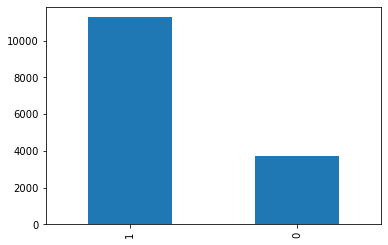

In [11]:
train_data['target'].value_counts().plot(kind = 'bar')

In [12]:
print(train_data.groupby('target').size().reset_index(name = 'count'))

   target  count
0       0   3738
1       1  11266


In [13]:
print(train_data.isnull().values.any())

False


In [14]:
print(train_data.isnull().sum())

Unnamed: 0    0
sentence      0
target        0
dtype: int64


In [15]:
train_data.loc[train_data.sentence.isnull()]

,Unnamed: 0,sentence,target


In [16]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [17]:
print(len(train_data))

15004


In [18]:
train_data['sentence'] = train_data['sentence'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
# 한글과 공백을 제외하고 모두 제거
train_data[:5]

<ipython-input-18-f2430c7e0838>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['sentence'] = train_data['sentence'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


,Unnamed: 0,sentence,target
0,0,일안하는 시간은 쉬고싶어서 그런게 아닐까,0
1,1,아동성범죄와 페도버는 기록바 끊어져 영원히 고통 받는다 무슬림 퍼 근친이다 까지 ...,1
2,2,루나 솔로앨범 나왔을 때부터 머모 기운 있었음 ㅇㅇ 진짜 띵곡임 꼭 들어보셈,0
3,3,홍팍에도 어버이연합인가 보내요 뭐 이런뎃글 있는데 이거 어버이연합측에 신고하면 그쪽...,0
4,4,아놔 왜 여기 댓들은 다 여자들이 김치녀라고 먼저 불렸다 여자들은 더 심하게 그런다...,1


In [19]:
train_data['sentence'] = train_data['sentence'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
train_data['sentence'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

Unnamed: 0     0
sentence      24
target         0
dtype: int64


<ipython-input-19-bc5c82268599>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['sentence'] = train_data['sentence'].str.replace('^ +', "") # white space 데이터를 empty value로 변경


In [20]:
train_data.loc[train_data.sentence.isnull()][:5]

,Unnamed: 0,sentence,target
572,572,NaN,0
1054,1054,NaN,0
1469,1469,NaN,1
1646,1646,NaN,1
1996,1996,NaN,0


In [21]:
train_data = train_data.dropna(how = 'any')

In [22]:
print(len(train_data))

14980


In [23]:
test_data.drop_duplicates(subset = ['sentence'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['sentence'] = test_data['sentence'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['sentence'] = test_data['sentence'].str.replace('^ +', "") # 공백은 empty 값으로 변경
test_data['sentence'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 3730


<ipython-input-23-37159e8dcb43>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['sentence'] = test_data['sentence'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
<ipython-input-23-37159e8dcb43>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['sentence'] = test_data['sentence'].str.replace('^ +', "") # 공백은 empty 값으로 변경


In [24]:
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 3730


In [25]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [26]:
okt = Okt()

In [27]:
X_train = []
for sentence in tqdm(train_data['sentence']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence)

100%|███████████████████████████████████████████████████████████████████████████| 14980/14980 [01:05<00:00, 229.58it/s]


In [28]:
X_test = []
for sentence in tqdm(test_data['sentence']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

100%|█████████████████████████████████████████████████████████████████████████████| 3730/3730 [00:19<00:00, 187.56it/s]


In [29]:
print('전처리 후 테스트용 샘플의 개수 :',len(X_test))

전처리 후 테스트용 샘플의 개수 : 3730


In [30]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [31]:
print(tokenizer.word_index)

{'을': 1, '새끼': 2, '보다': 3, '아니다': 4, '되다': 5, '있다': 6, '다': 7, '없다': 8, '로': 9, '같다': 10, '이다': 11, '안': 12, '저': 13, '에서': 14, '만': 15, '나': 16, '여자': 17, '고': 18, '못': 19, '들다': 20, 'ㅋㅋ': 21, '좆': 22, '아': 23, '거': 24, '왜': 25, '그렇다': 26, '야': 27, '적': 28, '사람': 29, '그': 30, '하고': 31, '진짜': 32, '게': 33, '년': 34, 'ㅋㅋㅋ': 35, '말': 36, '가다': 37, '것': 38, '남자': 39, '않다': 40, '이기': 41, '인': 42, '받다': 43, '존나': 44, '네': 45, '좋다': 46, '한남': 47, '지': 48, '더': 49, '개': 50, '니': 51, '뭐': 52, '오다': 53, '먹다': 54, '한국': 55, '생각': 56, '씨발': 57, '애': 58, 'ㅋㅋㅋㅋ': 59, '라': 60, '내': 61, '충': 62, '면': 63, '많다': 64, '지다': 65, '딱': 66, '알다': 67, '페미': 68, '그냥': 69, '맞다': 70, '인데': 71, '한테': 72, '때': 73, '놈': 74, '치다': 75, '나오다': 76, '임': 77, '하': 78, '일': 79, '전라도': 80, '냐': 81, '병신': 82, '들이다': 83, '시발': 84, '시키다': 85, '나라': 86, '나다': 87, '모르다': 88, '살다': 89, '내다': 90, '똥꼬': 91, '돈': 92, '쓰다': 93, '서': 94, '이나': 95, '보지': 96, '글': 97, '동성애': 98, '저런': 99, '일베': 100, '홍어': 101, '안되다': 102, '버리다': 103, '수'

In [32]:
print(tokenizer.word_counts.items())

odict_items([('이다', 974), ('시간', 70), ('쉬다', 54), ('그렇다', 662), ('아니다', 1516), ('아동', 15), ('성범죄', 25), ('페도버', 1), ('기록', 4), ('바', 38), ('끊어지다', 1), ('영원하다', 14), ('고통', 18), ('받다', 519), ('무슬림', 154), ('퍼', 29), ('근', 30), ('친', 30), ('까지', 257), ('떨어지다', 60), ('출산', 31), ('위험', 7), ('다', 1486), ('루나', 1), ('솔로', 1), ('앨범', 1), ('나오다', 376), ('때', 402), ('부터', 229), ('머모', 5), ('기운', 4), ('있다', 1505), ('ㅇㅇ', 70), ('진짜', 635), ('띵곡임', 1), ('꼭', 84), ('들다', 755), ('보다', 1566), ('홍팍', 2), ('에도', 86), ('어버이연합', 2), ('인가', 108), ('보내다', 115), ('뭐', 471), ('이런', 102), ('뎃글', 1), ('거', 684), ('측', 5), ('신고', 48), ('그', 640), ('쪽', 59), ('에서', 917), ('고소', 26), ('가능하다', 59), ('아', 702), ('놓다', 92), ('왜', 679), ('여기', 85), ('댓', 19), ('여자', 814), ('김치', 226), ('녀', 165), ('라고', 267), ('먼저', 40), ('불리다', 6), ('더', 482), ('심하다', 39), ('이렇게', 122), ('개', 480), ('로', 1084), ('싸우다', 52), ('내', 446), ('볼', 33), ('땐', 28), ('두다', 100), ('나쁘다', 68), ('말', 613), ('이상', 84), ('이하', 19), ('고', 802), ('

In [33]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 18182
등장 빈도가 2번 이하인 희귀 단어의 수: 11425
단어 집합에서 희귀 단어의 비율: 62.836871631283685
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 7.2689247886578405


In [34]:
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 6758


In [35]:
tokenizer = Tokenizer(vocab_size) # 빈도수 2 이하인 단어는 제거
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [36]:
y_train = np.array(train_data['target'])
y_test = np.array(test_data['target'])

In [37]:
print(len(X_train))
print(len(y_train))

14980
14980


In [38]:
print(X_train[:3])

[[11, 440, 583, 26, 4], [1789, 1197, 4461, 824, 1887, 1544, 43, 206, 1062, 1034, 1035, 11, 113, 518, 1000, 3088, 7], [76, 73, 128, 3889, 4462, 6, 441, 32, 373, 20, 3]]


In [39]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]
drop_test = [index for index, sentence in enumerate(X_test) if len(sentence) < 1]

In [40]:
print(drop_train)

[182, 382, 974, 1090, 1204, 1608, 1795, 2058, 2310, 2389, 2740, 2819, 2957, 3098, 3164, 3277, 3497, 3598, 3601, 3772, 3904, 4310, 4542, 5193, 6153, 6675, 6765, 7088, 7201, 7495, 7507, 7593, 7983, 8198, 8835, 9657, 10622, 12115, 12117, 12148, 12405, 12558, 12622, 12643, 12839, 12930, 13197, 13207, 13333, 13423, 13710, 13998, 14016, 14063]


In [41]:
len(drop_train)

54

In [42]:
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)

C:\Users\jisoo\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [43]:
print(len(X_train))
print(len(y_train))

14926
14926


In [44]:
print(len(X_test))
print(len(y_test))

3730
3730


In [45]:
X_test = np.delete(X_test, drop_test, axis=0)

In [46]:
y_test = np.delete(y_test, drop_test, axis=0)

In [47]:
print(len(X_test))
print(len(y_test))

3713
3713


리뷰의 최대 길이 : 72
리뷰의 평균 길이 : 11.971727187458127


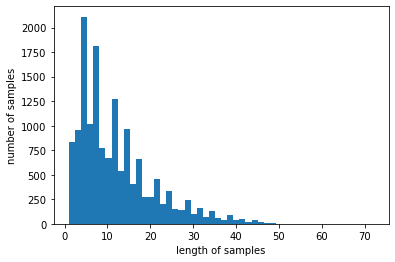

In [48]:
print('문장의 최대 길이 :',max(len(l) for l in X_train))
print('문장의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [49]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [50]:
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 95.0623073830899


In [51]:
# 전체 데이터의 길이는 30으로 맞춘다.
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

# 2. Multi-Kernel 1D CNN으로 혐오 발언 분류하기

In [52]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense, Input, Flatten, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

In [53]:
embedding_dim = 128
dropout_ratio = (0.5, 0.8)
num_filters = 128
hidden_units = 128

In [54]:
model_input = Input(shape = (max_len,))
z = Embedding(vocab_size, embedding_dim, input_length = max_len, name="embedding")(model_input)
z = Dropout(dropout_ratio[0])(z)

In [55]:
conv_blocks = []

for sz in [3, 4, 5]:
    conv = Conv1D(filters = num_filters,
                         kernel_size = sz,
                         padding = "valid",
                         activation = "relu",
                         strides = 1)(z)
    conv = GlobalMaxPooling1D()(conv)
    conv_blocks.append(conv)

In [56]:
z = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]
z = Dropout(dropout_ratio[1])(z)
z = Dense(hidden_units, activation="relu")(z)
model_output = Dense(1, activation="sigmoid")(z)

model = Model(model_input, model_output)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["acc"])

In [57]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 30, 128)      865024      input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 30, 128)      0           embedding[0][0]                  
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 28, 128)      49280       dropout[0][0]                    
______________________________________________________________________________________________

In [58]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('CNN_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.fit(X_train, y_train, batch_size = 64, epochs=10, validation_split = 0.2, verbose=2, callbacks=[es, mc])

Epoch 1/10
187/187 - 5s - loss: 0.4740 - acc: 0.7678 - val_loss: 0.4001 - val_acc: 0.8145

Epoch 00001: val_acc improved from -inf to 0.81447, saving model to CNN_model.h5
Epoch 2/10
187/187 - 4s - loss: 0.3385 - acc: 0.8464 - val_loss: 0.3704 - val_acc: 0.8272

Epoch 00002: val_acc improved from 0.81447 to 0.82719, saving model to CNN_model.h5
Epoch 3/10
187/187 - 4s - loss: 0.2670 - acc: 0.8835 - val_loss: 0.3887 - val_acc: 0.8218

Epoch 00003: val_acc did not improve from 0.82719
Epoch 4/10
187/187 - 4s - loss: 0.2224 - acc: 0.9101 - val_loss: 0.4170 - val_acc: 0.8212

Epoch 00004: val_acc did not improve from 0.82719
Epoch 5/10
187/187 - 4s - loss: 0.1895 - acc: 0.9221 - val_loss: 0.4623 - val_acc: 0.8218

Epoch 00005: val_acc did not improve from 0.82719
Epoch 6/10
187/187 - 4s - loss: 0.1605 - acc: 0.9348 - val_loss: 0.5159 - val_acc: 0.8131

Epoch 00006: val_acc did not improve from 0.82719
Epoch 00006: early stopping


In [59]:
loaded_model = load_model('CNN_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

117/117 [==============================] - ETA: 0s - loss: 0.3660 - acc: 0.826 - 0s 3ms/step - loss: 0.3649 - acc: 0.8271

 테스트 정확도: 0.8271


In [ ]:
from keras.models import load_model

model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'
del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
model = load_model('my_model.h5')

In [64]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

clf = LogisticRegression(solver="liblinear", random_state=0).fit(X_test, y_test)

# roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]) 
AUC = roc_auc_score(y_test, clf.decision_function(X_test))     

y_pred = model.predict(X_test)
precision = precision_score(y_test, np.round(abs(y_pred))) 
f1 = f1_score(y_test, np.round(abs(y_pred))) 

print("AUC : ", AUC)
print("Precision Score : ", precision)
print("f1 Score : ", f1)

AUC :  0.6494465435060818
Precision Score :  0.8607681755829903
f1 Score :  0.8783902012248469


# 3. 혐오 발언 예측해보기

In [61]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 혐오 발언입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 일반 발언입니다.\n".format((1 - score) * 100))

In [62]:
sentiment_predict('아이스크림 먹고싶다')

65.64% 확률로 일반 발언입니다.



In [63]:
sentiment_predict('야 이 나쁜 놈아')

64.23% 확률로 혐오 발언입니다.

